# Hamiltonian Simulation by Generalized Quantum Signal Processing

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `HamiltonianSimulationByGQSP`
Hamiltonian simulation using Generalized QSP given a qubitized quantum walk operator.

Given the Szegedy Quantum Walk Operator for a Hamiltonian $H$ constructed from SELECT and PREPARE oracles,
one can construct a block-encoding of $e^{-iHt}$ using GQSP (Corollary 8).

### Recap: Qubitization Walk Operator

For a Hamiltonian $H = \sum_j \alpha_j U_j$ where $U_j$ are unitaries and $\alpha_j \ge 0$,
we are given the SELECT and PREPARE oracles:
$$ \text{SELECT} = \sum_j |j\rangle\langle j| \otimes U_j $$
$$ \text{PREPARE} |0\rangle = \sum_j \frac{\sqrt{\alpha_j}}{\|\alpha\|_1} |j\rangle $$

We can then implement the [QubitizationWalkOperator](../qubitization_walk_operator.ipynb) that encodes the spectrum of $H$ in the eigenphases of the walk operator $W$.

### Approximating the function $e^{i\theta} \mapsto e^{it\cos\theta}$

We can use the [Jacobi-Anger expansion](https://en.wikipedia.org/wiki/Jacobi%E2%80%93Anger_expansion) to obtain low-degree polynomial approximations for the $\cos$ function:

$$
    e^{it\cos\theta} = \sum_{n = -\infty}^{\infty} i^n J_n(t) (e^{i\theta})^n
$$
where $J_n$ is the $n$-th [Bessel function of the first kind](https://en.wikipedia.org/wiki/Bessel_function#Bessel_functions_of_the_first_kind).

If we cut-off the above to terms upto degree $d$, we get

$$
    P[t](z) = \sum_{n = -d}^d i^n J_n(t) z^n
$$

Polynomial approximations of the above are provided in the [`qualtran.linalg.jacobi_anger_approximations`](../../linalg/jacobi_anger_approximations.py) module.

### Simulation: Block-encoding $e^{-iHt}$

As the eigenphases of the walk operator above are $e^{-i\arccos(E_k / \|\alpha\|_1)}$,
we can use the GQSP polynomial with $P = P[-\|\alpha\|_1 t]$ to obtain $P(U) = e^{-iHt}$.
The obtained GQSP operator $G$ can then be used with two calls to the PREPARE oracle to simulate the hamiltonian:

$$
    (I \otimes \text{PREPARE}^\dagger \otimes I) G (I \otimes \text{PREPARE} \otimes I) |0\rangle|0\rangle|\psi\rangle = |0\rangle|0\rangle e^{-iHt}|\psi\rangle
$$

This therefore block-encodes $e^{-iHt}$ in the block where the signal qubit and selection registers are all $|0\rangle$.

#### References
 - [Generalized Quantum Signal Processing](https://arxiv.org/abs/2308.01501).     Motlagh and Wiebe. (2023). Theorem 7, Corollary 8. 

#### Parameters
 - `walk_operator`: qubitization walk operator of $H$ constructed from SELECT and PREPARE oracles.
 - `t`: time to simulate the Hamiltonian, i.e. $e^{-iHt}$
 - `alpha`: the $1$-norm of the coefficients of the unitaries comprising the Hamiltonian $H$.
 - `precision`: the precision $\epsilon$ to approximate $e^{it\cos\theta}$ to a polynomial.


In [2]:
from qualtran.bloqs.hamiltonian_simulation.hamiltonian_simulation_by_gqsp import HamiltonianSimulationByGQSP

### Example Instances

In [3]:
from qualtran.bloqs.hubbard_model import get_walk_operator_for_hubbard_model

walk_op = get_walk_operator_for_hubbard_model(2, 2, 1, 1)
hubbard_time_evolution_by_gqsp = HamiltonianSimulationByGQSP(
    walk_op, t=5, alpha=1, precision=1e-7
)

#### Graphical Signature

In [4]:
from qualtran.drawing import show_bloqs
show_bloqs([hubbard_time_evolution_by_gqsp],
           ['`hubbard_time_evolution_by_gqsp`'])

### Call Graph

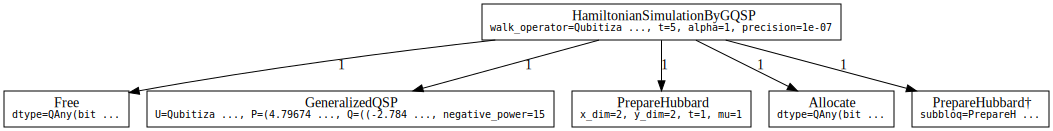

#### Counts totals:
 - `Adjoint(subbloq=PrepareHubbard(x_dim=2, y_dim=2, t=1, mu=1))`: 1
 - `Allocate(dtype=QAny(bitsize=2))`: 1
 - `Free(dtype=QAny(bitsize=2))`: 1
 - `GeneralizedQSP(U=QubitizationWalkOperator(select=SelectHubbard(x_dim=2, y_dim=2, control_val=None), prepare=PrepareHubbard(x_dim=2, y_dim=2, t=1, mu=1), control_val=None, power=1), P=(4.796741607254014e-07j, (-2.8012948341383013e-06+0j), -1.5207576910449053e-05j, (7.627810510019691e-05+0j), 0.00035092732757049494j, (-0.0014678021362099828+0j), -0.005520281217269446j, (0.01840521024595998+0j), 0.05337639156980253j, (-0.13104868614948714+0j), -0.26114045518896645j, (0.3912322242284459+0j), 0.3648311035765469j, (-0.046565100063410525+0j), 0.3275790235258185j, (-0.17759670947373796+0j), 0.3275790235258185j, (-0.046565100063410525+0j), 0.3648311035765469j, (0.3912322242284459+0j), -0.26114045518896645j, (-0.13104868614948714+0j), 0.05337639156980253j, (0.01840521024595998+0j), -0.005520281217269446j, (-0.0014678021362099828+0j), 0.00035092732757049494j, (7.627810510019691e-05+0j), -1.5207576910449053e-05j, (-2.8012948341383013e-06+0j), 4.796741607254014e-07j), Q=((-2.7849987216524566e-10-2.569542707536054e-25j), (-7.435272515423475e-25+4.040851927646911e-21j), (8.162365350347383e-09+1.3296016733463155e-23j), (7.837651969199334e-23-1.1297695397459083e-19j), (-1.70202027196286e-07-5.374389921736686e-22j), (-1.5227438111587277e-21+2.308793123795399e-18j), (2.3340586104644187e-06+8.95731653622781e-21j), (9.315609197676923e-21-3.0483539636090485e-17j), (-1.84320508591336e-05-7.739121487300827e-20j), (-8.599023874778698e-20+2.2079426969140102e-16j), (6.294434019397928e-05+4.0917021937488637e-19j), (4.417748515667556e-19-5.391129354879588e-16j), (-1.7161719760110186e-05-1.163734564386717e-18j), (-1.1494028579287526e-18-1.0209334412395588e-15j), (-4.207923270831525e-05+1.4116730861095029e-18j), (1.5542735653662496e-18+9.013382171891366e-16j), (-2.02233244217195e-05-4.629141185922532e-19j), (-4.299511937389349e-20+4.194672638308047e-15j), (8.054827402869949e-05+7.452487358141538e-19j), (2.7803510528451124e-19+4.7899085362853944e-15j), (-2.2700710556802724e-05-1.9362135424710032e-18j), (-1.3987745502973349e-18-3.4160803275170515e-14j), (-4.020155567231802e-06+4.494423145217666e-18j), (-7.452487358141538e-19+2.7008272800511587e-15j), (9.059107472157617e-07-5.113552864201732e-18j), (3.846630013317671e-18+1.2706376291979658e-15j), (6.224591868451106e-06+7.429556627808795e-18j), (2.132557920945117e-18-1.6518472625416217e-14j), (4.8948989929085175e-06-4.293779254806163e-18j), (1.9720428086159147e-18-1.1982040382228966e-14j), (0.0008261666286550046+0j)), negative_power=15)`: 1
 - `PrepareHubbard(x_dim=2, y_dim=2, t=1, mu=1)`: 1

In [5]:
from qualtran.resource_counting.generalizers import ignore_split_join
hubbard_time_evolution_by_gqsp_g, hubbard_time_evolution_by_gqsp_sigma = hubbard_time_evolution_by_gqsp.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(hubbard_time_evolution_by_gqsp_g)
show_counts_sigma(hubbard_time_evolution_by_gqsp_sigma)